<a href="https://colab.research.google.com/github/Dvaalmeyda/deteksi-kemiripan-judul-skripsi/blob/main/ADAM_FINAL_MODELING_Skripsi_Diva_Putra_Almeyda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pemodelan Cek Kemiripan Judul Skripsi - Kombinasi Hyperparameter Adam

### Setup

In [ ]:
!pip install transformers==4.36.0
!pip install keras==2.15.0
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 72.5 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.0
    Uninstalling tokenizers-0.21.0:
      Successfully uninstalled tokenizers-0.21.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.1
    Uninstalling transformers-4.47.1:
      Successfully uninstalled transformers-4.47.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.3.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.36.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 43.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found

In [ ]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, KFold
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
plt.style.use('ggplot')

In [ ]:
# URL dataset
finetuning_dataset_url = 'https://docs.google.com/spreadsheets/d/1YAuYZa_LFqxqOpiMgFr-imZRoiIaNSZGDscOvY30tb8/export?gid=287899900&format=csv'

In [ ]:
# Load dataset format csv untuk kolom ['judul 1 processed', 'judul 2 processed', 'Label']
tuning_stem_skripsi_df = pd.read_csv(finetuning_dataset_url, usecols=['judul 1 processed', 'judul 2 processed', 'label'])

In [ ]:
# Hitung total label 1 & 0
total_label_1 = len(tuning_stem_skripsi_df[tuning_stem_skripsi_df['label'] == 1])
total_label_0 = len(tuning_stem_skripsi_df[tuning_stem_skripsi_df['label'] == 0])

print('Total Label 1:', total_label_1)
print('\n===========\n')
print('Total Label 0:', total_label_0)

Total Label 1: 2532


Total Label 0: 2936


In [ ]:
tuning_stem_skripsi_df

,judul 1 processed,judul 2 processed,label
0,implementasi mikroprosesor z80 pengendali lift,proses pengiriman data saluran udara tegangan,1
1,analisis kinerja electrostatic precipitator es...,pemeliharaan trafo distribusi pt pln persero r...,1
2,studi penyaluran pusat pengatur beban jawa bal...,studi rangkaian unit penggulung pt industri sa...,1
3,analisis pengaruh putaran rotor ayunan beban s...,pemeliharaan generator unit 2 pt indonesia pow...,1
4,analisis pengaruh putaran rotor ayunan beban s...,inverter kendali kestabilan putaran motor mesi...,1
...,...,...,...
5463,proses pengiriman data saluran udara tegangan,setting koordinasi over current relay trafo 2 ...,0
5464,central power supply dilengkapi meter tegangan...,recloser pengaman arus sistem jaringan distrib...,0
5465,mikrokontroler pengendali aliran kapas pt indu...,inverter kendali kestabilan putaran motor mesi...,0
5466,analisa nilai pertanahan peralatan gardu induk...,analisis kandungan air isolasi kertas generato...,0


### Setup Dataset for Input

In [ ]:
# Split the dataset
# First split: 80% (train + val), 20% test
stem_train_val_df, stem_test_df = train_test_split(tuning_stem_skripsi_df, test_size=0.2, random_state=42, stratify=tuning_stem_skripsi_df['label'])
# Second split: 80% train, 20% val
stem_train_df, stem_val_df = train_test_split(stem_train_val_df, test_size=0.2, random_state=42, stratify=stem_train_val_df['label'])

# Print result
print(f"Training samples: {len(stem_train_df)}")
print(f"Validation samples: {len(stem_val_df)}")
print(f"Test samples: {len(stem_test_df)}")

Training samples: 3499
Validation samples: 875
Test samples: 1094


In [ ]:
# Hitung distribusi label di train, validation, dan test sets
print("Train & Val label distribution:")
print(stem_train_val_df['label'].value_counts(normalize=True))

print("Train label distribution:")
print(stem_train_df['label'].value_counts(normalize=True))

print("\nValidation label distribution:")
print(stem_val_df['label'].value_counts(normalize=True))

print("\nTest label distribution:")
print(stem_test_df['label'].value_counts(normalize=True))

Train & Val label distribution:
label
0    0.537037
1    0.462963
Name: proportion, dtype: float64
Train label distribution:
label
0    0.537011
1    0.462989
Name: proportion, dtype: float64

Validation label distribution:
label
0    0.537143
1    0.462857
Name: proportion, dtype: float64

Test label distribution:
label
0    0.536563
1    0.463437
Name: proportion, dtype: float64


In [ ]:
# Load tokenizer model
indobertTokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-lite-large-p2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/225k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.54k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [ ]:
# Helper Function - Ck total vocab pada model
def totalVocab(tokenizer):
  vocabulary = tokenizer.get_vocab()
  print('Panjang vocabulary:', len(vocabulary))
  print(vocabulary)

# Cek total vocab
totalVocab(indobertTokenizer)

Panjang vocabulary: 29999
{'[PAD]': 0, '[UNK]': 1, '[CLS]': 2, '[SEP]': 3, '[MASK]': 4, '##an': 5, 'd': 6, '##er': 7, 'm': 8, '##en': 9, 's': 10, 'p': 11, '##ar': 12, 'b': 13, 'k': 14, '##at': 15, '##ang': 16, '##in': 17, 't': 18, '##ak': 19, '##al': 20, '##ah': 21, '##as': 22, '##un': 23, '##am': 24, '##em': 25, 'di': 26, '##ya': 27, '##el': 28, '##ad': 29, '##eng': 30, 'y': 31, '##kan': 32, '##tu': 33, 'yang': 34, 'se': 35, '##ap': 36, '##is': 37, 'l': 38, '##ik': 39, 'h': 40, 'dan': 41, 'j': 42, 'ke': 43, '##il': 44, 'men': 45, '##on': 46, '##it': 47, 'in': 48, 'ber': 49, '##us': 50, '##ga': 51, '##or': 52, '##es': 53, 'ter': 54, '##ing': 55, 'r': 56, '##nya': 57, '##ur': 58, '##akan': 59, 'mem': 60, 'c': 61, 'per': 62, '##ut': 63, '##id': 64, '##ari': 65, '##ul': 66, '##um': 67, 'n': 68, '##ada': 69, '##uk': 70, '##ek': 71, '##ir': 72, '##ol': 73, '##ih': 74, '##engan': 75, '##ung': 76, '##eb': 77, 'un': 78, 'dengan': 79, 'meng': 80, '##tuk': 81, '##ag': 82, 'g': 83, '##et': 84, '#

In [ ]:
# Helper Function - Coba set masukan dengan bert tokenizer
def format_bert_input_similarity(text1, text2, tokenizer, max_length=50):
    bert_input = tokenizer.encode_plus(
        text1,
        text2,
        add_special_tokens = True,
        padding = 'max_length',
        truncation = True,
        max_length = max_length,
        return_attention_mask = True,
        return_token_type_ids = True
    )

    # Menampilkan hasil input formatting
    print("Kalimat 1:", text1)
    print("Kalimat 2:", text2)
    print("Tokenizer:", tokenizer.convert_ids_to_tokens(bert_input['input_ids']))
    print("Input IDs:", bert_input['input_ids'])
    print("Token Type IDs:", bert_input['token_type_ids'])
    print("Attention Mask:", bert_input['attention_mask'])
    print('\n')
    return bert_input

# Demo pada data baris pertama
judul_1 = tuning_stem_skripsi_df['judul 1 processed'][1]
judul_2 = tuning_stem_skripsi_df['judul 2 processed'][1]

bert_input_tokenizer2 = format_bert_input_similarity(judul_1, judul_2, indobertTokenizer)

Kalimat 1: analisis kinerja electrostatic precipitator esp ptindonesia power unit pembangkitan suralaya
Kalimat 2: pemeliharaan trafo distribusi pt pln persero rayon magelang kota
Tokenizer: ['[CLS]', 'analisis', 'kinerja', 'electr', '##ost', '##atic', 'prec', '##ipi', '##tator', 'esp', 'pt', '##indonesia', 'power', 'unit', 'pembangkit', '##an', 'sura', '##lay', '##a', '[SEP]', 'pemeliharaan', 'trafo', 'distribusi', 'pt', 'pln', 'persero', 'rayon', 'magelang', 'kota', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Input IDs: [2, 3169, 3132, 8274, 2197, 10694, 22561, 10811, 27969, 17009, 914, 6664, 3939, 2027, 11167, 5, 1936, 7490, 29832, 3, 6749, 24609, 6413, 914, 6535, 4413, 18386, 10225, 626, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Token Type IDs: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,

In [ ]:
# Helper Function - Token Embeddings
def encode(data, tokenizer, max_length=70):
    # Get data judul 1, judul 2, label dalam bentuk list
    judul1 = data['judul 1 processed'].tolist()
    judul2 = data['judul 2 processed'].tolist()
    labels = data['label'].tolist()

    # Tokenisasi dengan `batch_encode_plus`, otomatis mengembalikan TensorFlow tensors
    bert_inputs = tokenizer(
        judul1,
        judul2,
        add_special_tokens = True,
        padding = 'max_length',
        truncation = True,
        max_length = max_length,
        return_attention_mask = True,
        return_token_type_ids = True,
        return_tensors = 'tf',  # Mengembalikan format TensorFlow
        verbose = False,
        return_overflowing_tokens=False
    )

    # Menggabungkan input dan label dalam tf.data.Dataset
    return tf.data.Dataset.from_tensor_slices(({
        "input_ids": bert_inputs['input_ids'],
        "attention_mask": bert_inputs['attention_mask'],
        "token_type_ids": bert_inputs['token_type_ids']
    }, labels))

In [ ]:
# Pembuatan Input untuk pemodelan
train_dataset_tokenEmbeddings = encode(stem_train_df, indobertTokenizer, max_length=70)
valdataset_tokenEmbeddings = encode(stem_val_df, indobertTokenizer, max_length=70)
testdataset_tokenEmbeddings = encode(stem_test_df, indobertTokenizer, max_length=70)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

### Compile Model

In [ ]:
# Set total kelas
num_classes = len(stem_train_df['label'].unique())
num_classes

2

In [ ]:
# Set model name
indobertModel_name = "indolem/indobert-base-uncased"

In [ ]:
# Load model pre-trained indobert untuk fine tuning
indobertModel = TFBertForSequenceClassification.from_pretrained(
    indobertModel_name, num_labels=num_classes,
    hidden_dropout_prob=0.1, attention_probs_dropout_prob=0.1,
    from_pt=True
)

### Fine-tuning - final

In [ ]:
# Max accuracy callback
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        # Cek apakah accuracy dan val_accuracy keduanya lebih dari 0.95
        if logs.get('accuracy') is not None and logs.get('val_accuracy') is not None:
            if logs['accuracy'] > 0.95 and logs['val_accuracy'] > 0.95:
                print("\nReached 95% accuracy and validation accuracy so cancelling training!")
                self.model.stop_training = True

myCallback = myCallback()

In [ ]:
# Early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
# Optimizer and loss function
optimizerFinal = keras.optimizers.Adam(learning_rate=3e-5)
lossFinal = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
# Compile model
indobertModel.compile(
    optimizer=optimizerFinal,
    loss=lossFinal,
    metrics=[
        "accuracy"
    ]
)

##### KFold Cross Validation

In [ ]:
# Kfold Cross Validation setup
num_folds = 5
kfold = KFold(n_splits=5, shuffle=True)
num_epochs = 3

# Set Batch size
batch_size = 64

results = []

In [ ]:
# Simpan bobot awal model
initial_weights = indobertModel.get_weights()

In [ ]:
# non-aktifkan notifikasi warning
from transformers import logging

logging.set_verbosity_error()

In [ ]:
for fold, (train_index, val_index) in enumerate(kfold.split(stem_train_val_df, stem_train_val_df['label'])):
    print(f"Starting Fold {fold + 1}\n")

    # Membagi data ke dalam train dan validation subset
    train_data = stem_train_val_df.iloc[train_index]
    val_data = stem_train_val_df.iloc[val_index]

    # Cetak distribusi label untuk train dan validation subset
    train_label_distribution = train_data['label'].value_counts()
    val_label_distribution = val_data['label'].value_counts()

    print(f"Train label distribution for Fold {fold + 1}:")
    print(train_label_distribution.to_string())
    print(f"\nValidation label distribution for Fold {fold + 1}:")
    print(val_label_distribution.to_string())
    print("\n")

    # Tokenize dan encode dataset
    train_dataset = encode(train_data, indobertTokenizer, max_length=70).batch(batch_size)
    val_dataset = encode(val_data, indobertTokenizer, max_length=70).batch(batch_size)

    # Reset model weights
    indobertModel.set_weights(initial_weights)

    # Train model pada setiap fold
    history_kfold = indobertModel.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=num_epochs,
        callbacks=[myCallback, early_stopping_callback]
    )

    # Menyimpan hasil pelatihan fold
    results.append(history_kfold)
    print(f"Fold {fold + 1} completed\n")

Starting Fold 1

Train label distribution for Fold 1:
label
0    1875
1    1624

Validation label distribution for Fold 1:
label
0    474
1    401


Epoch 1/3
55/55 [==============================] - 96s 996ms/step - loss: 0.6326 - accuracy: 0.6525 - val_loss: 0.4478 - val_accuracy: 0.8034
Epoch 2/3
55/55 [==============================] - 50s 901ms/step - loss: 0.3656 - accuracy: 0.8497 - val_loss: 0.3089 - val_accuracy: 0.8720
Epoch 3/3
55/55 [==============================] - 49s 894ms/step - loss: 0.2929 - accuracy: 0.8868 - val_loss: 0.2353 - val_accuracy: 0.9109
Fold 1 completed

Starting Fold 2

Train label distribution for Fold 2:
label
0    1873
1    1626

Validation label distribution for Fold 2:
label
0    476
1    399


Epoch 1/3
55/55 [==============================] - 50s 908ms/step - loss: 0.6175 - accuracy: 0.6656 - val_loss: 0.4355 - val_accuracy: 0.8114
Epoch 2/3
55/55 [==============================] - 50s 914ms/step - loss: 0.3459 - accuracy: 0.8628 - val_loss: 0.23

## Hasil CrossVal

In [ ]:
# List metrik per fold
val_losses = []
val_accuracies = []
train_losses = []
train_accuracies = []

In [ ]:
# Iterasi per fold
for fold, history in enumerate(results):
    # Ekstrak epoch dengan val_loss minimum
    min_val_loss_epoch = history.history['val_loss'].index(min(history.history['val_loss']))

    # Ekstrak semua metrik pada epoch tersebut
    min_val_loss = history.history['val_loss'][min_val_loss_epoch]
    val_accuracy = history.history['val_accuracy'][min_val_loss_epoch]
    train_loss = history.history['loss'][min_val_loss_epoch]
    train_accuracy = history.history['accuracy'][min_val_loss_epoch]

    # Simpan metrik (list)
    val_losses.append(min_val_loss)
    val_accuracies.append(val_accuracy)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Fold {fold + 1}:")
    print(f"  Epoch with Minimum val_loss: {min_val_loss_epoch + 1}")
    print(f"  Loss: {train_loss:.4f} | Accuracy: {train_accuracy:.4f}")
    print(f"  Val_Loss: {min_val_loss:.4f} | Val_Accuracy: {val_accuracy:.4f}")
    print("-" * 50)

Fold 1:
  Epoch with Minimum val_loss: 3
  Loss: 0.2929 | Accuracy: 0.8868
  Val_Loss: 0.2353 | Val_Accuracy: 0.9109
--------------------------------------------------
Fold 2:
  Epoch with Minimum val_loss: 3
  Loss: 0.2279 | Accuracy: 0.9125
  Val_Loss: 0.2042 | Val_Accuracy: 0.9257
--------------------------------------------------
Fold 3:
  Epoch with Minimum val_loss: 3
  Loss: 0.2101 | Accuracy: 0.9174
  Val_Loss: 0.1641 | Val_Accuracy: 0.9360
--------------------------------------------------
Fold 4:
  Epoch with Minimum val_loss: 3
  Loss: 0.2261 | Accuracy: 0.9131
  Val_Loss: 0.1544 | Val_Accuracy: 0.9394
--------------------------------------------------
Fold 5:
  Epoch with Minimum val_loss: 2
  Loss: 0.3399 | Accuracy: 0.8597
  Val_Loss: 0.2209 | Val_Accuracy: 0.9211
--------------------------------------------------


In [ ]:
# Hitung rata-rata dari semua metrik
avg_train_loss = sum(train_losses) / len(train_losses)
avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)
avg_val_loss = sum(val_losses) / len(val_losses)
avg_val_accuracy = sum(val_accuracies) / len(val_accuracies)

# Cetak rata-rata metrik
print("\nAverage Metrics Across All Folds:")
print(f"  Average Loss: {avg_train_loss:.4f} | Average Accuracy: {avg_train_accuracy:.4f}")
print(f"  Average Val_Loss: {avg_val_loss:.4f} | Average Val_Accuracy: {avg_val_accuracy:.4f}")


Average Metrics Across All Folds:
  Average Loss: 0.2594 | Average Accuracy: 0.8979
  Average Val_Loss: 0.1958 | Average Val_Accuracy: 0.9266


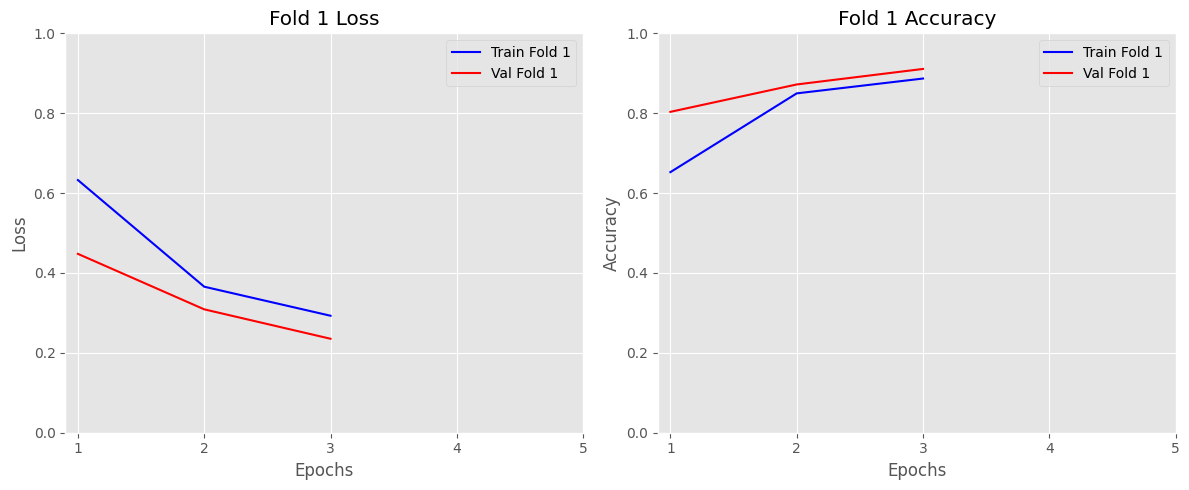

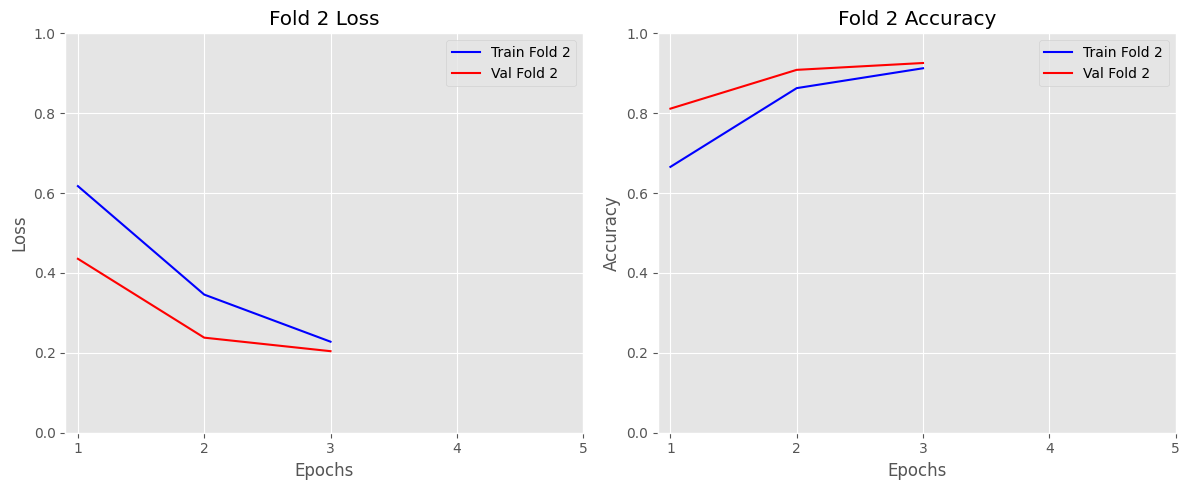

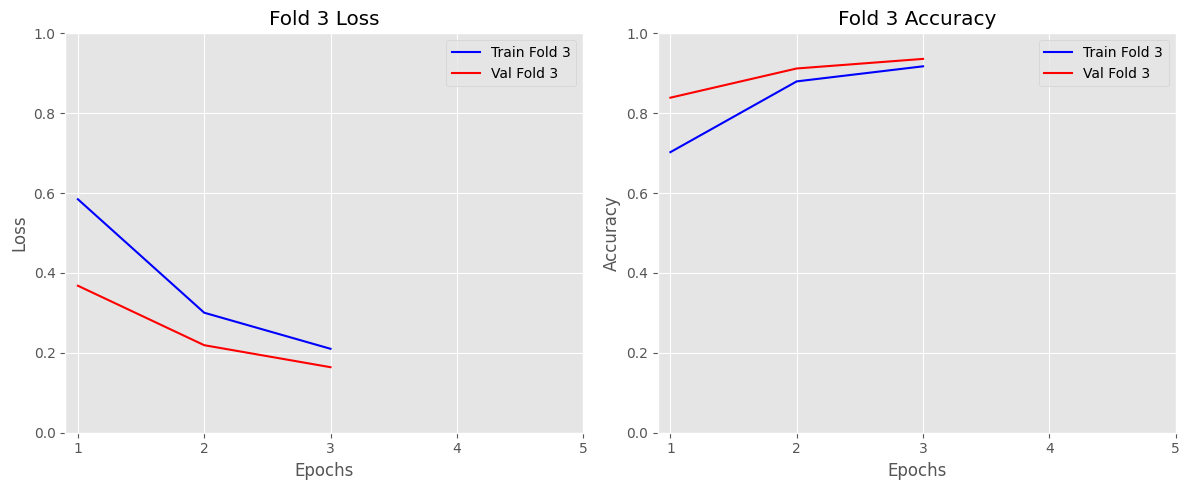

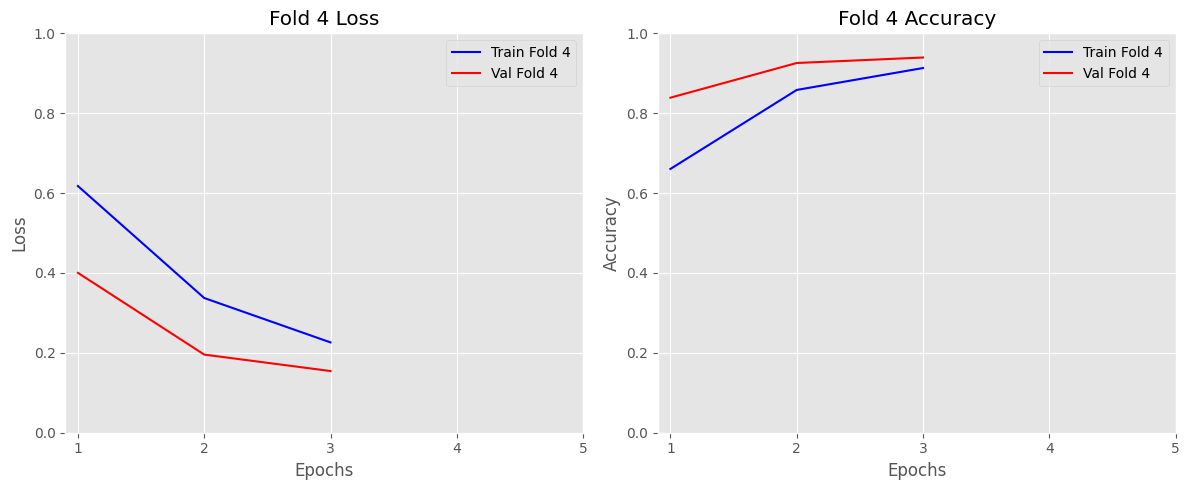

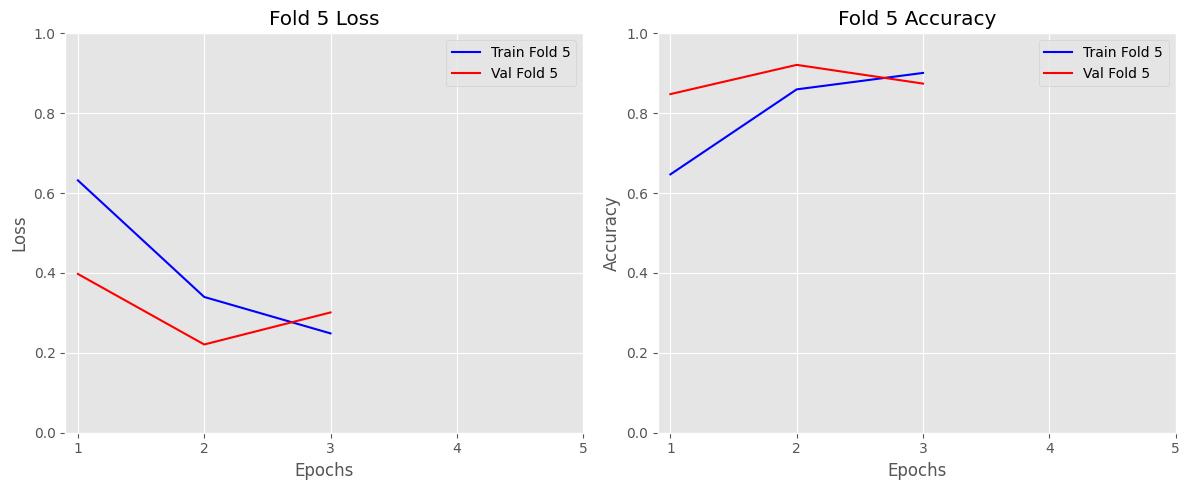

In [ ]:
# Inisialisasi list untuk menyimpan metrik
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Iterasi
for fold, history in enumerate(results):
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    train_accuracies.append(history.history['accuracy'])
    val_accuracies.append(history.history['val_accuracy'])
    # Total Epoch history
    epochs = range(1, len(history.history['loss']) + 1)

    # Plot
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label=f'Train Fold {fold + 1}', color='blue')
    plt.plot(epochs, history.history['val_loss'], label=f'Val Fold {fold + 1}', color='red')
    plt.title(f'Fold {fold + 1} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(ticks=range(1, 6))
    plt.yticks(ticks=np.linspace(0, 1, 6))
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label=f'Train Fold {fold + 1}', color='blue')
    plt.plot(epochs, history.history['val_accuracy'], label=f'Val Fold {fold + 1}', color='red')
    plt.title(f'Fold {fold + 1} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(ticks=range(1, 6))
    plt.yticks(ticks=np.linspace(0, 1, 6))
    plt.legend()

    plt.tight_layout()
    plt.show()

# Final Train Model

In [ ]:
# Load model
indobertModel = TFBertForSequenceClassification.from_pretrained(
    indobertModel_name, num_labels=num_classes,
    hidden_dropout_prob=0.1, attention_probs_dropout_prob=0.1,
    from_pt=True
)

In [ ]:
indobertModel.summary()

Model: "tf_bert_for_sequence_classification_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  110558208 
                                                                 
 dropout_151 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 110559746 (421.75 MB)
Trainable params: 110559746 (421.75 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Optimizer and Loss Function
optimizerFinal = keras.optimizers.Adam(learning_rate=1e-5)
lossFinal = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
# Compile model
indobertModel.compile(
    optimizer=optimizerFinal,
    loss=lossFinal,
    metrics=[
        "accuracy"
    ]
)

In [ ]:
# Load bobot awal model
indobertModel.set_weights(initial_weights)

In [ ]:
# Train model
history = indobertModel.fit(
    train_dataset_tokenEmbeddings.batch(64),
    validation_data=valdataset_tokenEmbeddings.batch(64),
    epochs=3,
    callbacks=[myCallback, early_stopping_callback]
)

Epoch 1/3
55/55 [==============================] - 92s 969ms/step - loss: 0.4895 - accuracy: 0.7705 - val_loss: 0.2686 - val_accuracy: 0.8971
Epoch 2/3
55/55 [==============================] - 51s 922ms/step - loss: 0.2355 - accuracy: 0.9097 - val_loss: 0.1663 - val_accuracy: 0.9429
Epoch 3/3
55/55 [==============================] - 49s 893ms/step - loss: 0.1655 - accuracy: 0.9331 - val_loss: 0.1337 - val_accuracy: 0.9543


##### Visualisasi

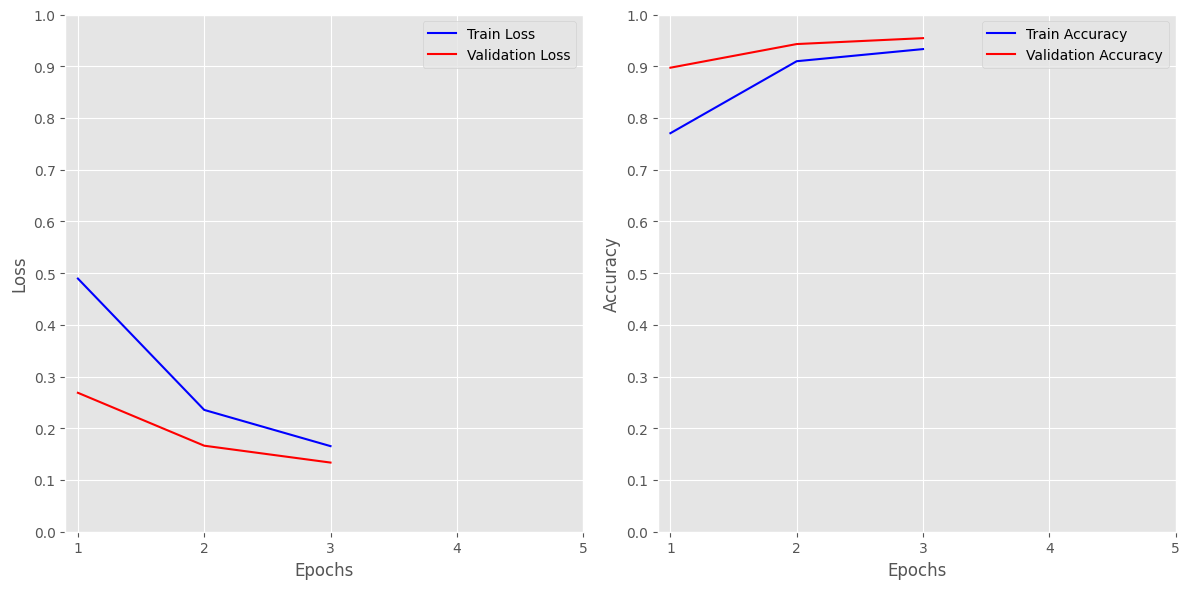

In [ ]:
# Epochs history
epochs = range(1, len(history.history['loss']) + 1)

# Plot
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], 'b-', label='Train Loss')
plt.plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, 6))
plt.yticks(ticks=np.linspace(0, 1, 11))
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], 'b-', label='Train Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, 6))
plt.yticks(ticks=np.linspace(0, 1, 11))
plt.legend()

plt.tight_layout()
plt.show()

# Save Model

In [ ]:
# Save model
path_model = '/content/drive/MyDrive/TERAKHIR_ADAM'
indobertModel.save_pretrained(path_model)

# Evaluation

In [ ]:
# Load Model
indobertModelX = TFBertForSequenceClassification.from_pretrained(path_model, num_labels=2)

In [ ]:
# Compile model
indobertModelX.compile(
    optimizer=optimizerFinal,
    loss=lossFinal,
    metrics=[
        "accuracy"
    ]
)

In [ ]:
# Hitung Akurasi
score_model = indobertModel.evaluate(testdataset_tokenEmbeddings.batch(32))
print("Test Accuracy:", score_model[1])

35/35 [==============================] - 6s 157ms/step - loss: 0.1548 - accuracy: 0.9470
Test Accuracy: 0.9469835758209229


In [ ]:
# Predict
predicted_raw = indobertModelX.predict(testdataset_tokenEmbeddings.batch(32))
y_pred = np.argmax(predicted_raw['logits'], axis=1)
y_true = np.array(stem_test_df['label'])

35/35 [==============================] - 11s 163ms/step


In [ ]:
# Helper Function - Visualisasi Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, class_labels=None):

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot
    plt.figure(figsize=(10, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    # Show
    plt.show()

In [ ]:
# Visualisasi
class_labels = ['0', '1']  # Set Label

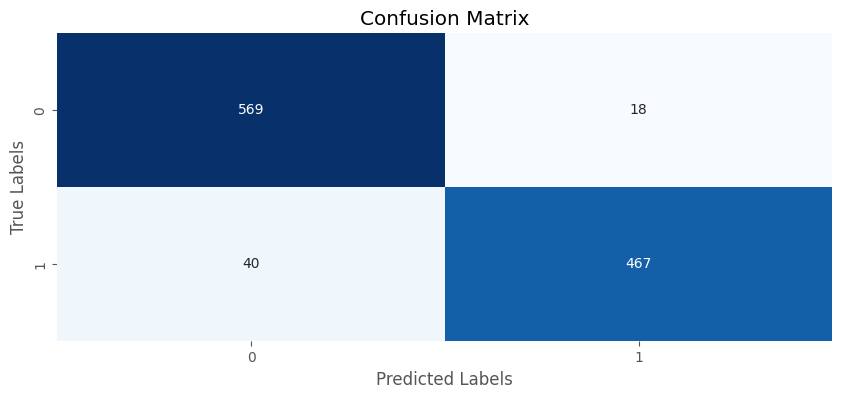

In [ ]:
plot_confusion_matrix(y_true, y_pred, class_labels)

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       587
           1       0.96      0.92      0.94       507

    accuracy                           0.95      1094
   macro avg       0.95      0.95      0.95      1094
weighted avg       0.95      0.95      0.95      1094



# DATA BARU

In [ ]:
# URL dataset
eval_dataset_url = 'https://docs.google.com/spreadsheets/d/1YAuYZa_LFqxqOpiMgFr-imZRoiIaNSZGDscOvY30tb8/export?gid=1020168489&format=csv'

# Load dataset format csv untuk kolom ['judul lama preprocessed', 'judul baru preprocessed', 'label']
data_baru_df = pd.read_csv(eval_dataset_url)

In [ ]:
#data_baru_df = data_baru_df.head(112)

In [ ]:
# Hitung total label 1 & 0
total_label_1 = len(data_baru_df[data_baru_df['label'] == 1])
total_label_0 = len(data_baru_df[data_baru_df['label'] == 0])

print('Total Label 1:', total_label_1)
print('\n===========\n')
print('Total Label 0:', total_label_0)

Total Label 1: 56


Total Label 0: 944


In [ ]:
# Gunakan encode function untuk mengubah data resampled menjadi format TensorFlow Dataset
data_baru_tokenEmbeddings = encode(data_baru_df, indobertTokenizer, max_length=70)

In [ ]:
# Hitung Akurasi
score_baru = indobertModel.evaluate(data_baru_tokenEmbeddings.batch(64))
print("Test Accuracy:", score_baru[1])

16/16 [==============================] - 5s 282ms/step - loss: 0.1449 - accuracy: 0.9510
Test Accuracy: 0.9509999752044678


In [ ]:
# Predict
baru_predicted_raw = indobertModel.predict(data_baru_tokenEmbeddings.batch(64))
baru_y_pred = np.argmax(baru_predicted_raw['logits'], axis=1)
baru_y_true = np.array(data_baru_df['label'])

16/16 [==============================] - 7s 280ms/step


In [ ]:
# Helper Function - Visualisasi Confusion Matrix
def baru_plot_confusion_matrix(y_true, y_pred, class_labels=None):

    # Confusion matrix
    cm = confusion_matrix(baru_y_true, baru_y_pred)

    # Plot
    plt.figure(figsize=(10, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    # Show
    plt.show()

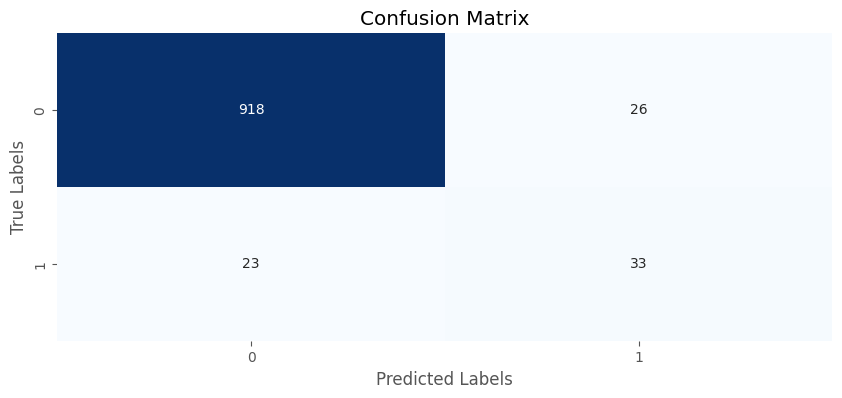

In [ ]:
# Visualisasi
baru_plot_confusion_matrix(baru_y_true, baru_y_pred, class_labels)

In [ ]:
print(classification_report(baru_y_true, baru_y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       944
           1       0.56      0.59      0.57        56

    accuracy                           0.95      1000
   macro avg       0.77      0.78      0.77      1000
weighted avg       0.95      0.95      0.95      1000



In [ ]:
# Pastikan jumlah prediksi sama dengan jumlah baris dalam DataFrame
assert len(baru_y_pred) == len(data_baru_df), "Jumlah prediksi tidak sesuai dengan jumlah data!"

In [ ]:
# Menambahkan kolom predicted label ke DataFrame
data_baru_df['predicted_label'] = baru_y_pred

In [ ]:
data_baru_df.to_excel("EVAL_RMS.xlsx")